In [20]:
## learning the keras API on toy data
import keras
from keras import layers, Sequential, Input
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import ARDRegression
from sklearn.decomposition import PCA, KernelPCA

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
)
x_train.shape

(404, 13)

In [4]:
def x_train_pplot(x_train):
    df = pd.DataFrame(x_train)
    sns.pairplot(df)
    plt.show()
# x_train_pplot(x_train)

In [16]:
all_metrics = ['MeanSquaredError', 'RootMeanSquaredError', 'MeanAbsoluteError', 'MeanAbsolutePercentageError', 'MeanSquaredLogarithmicError', 'CosineSimilarity', 'LogCoshError', ]
all_activators = ['relu','sigmoid','softmax','softplus','softsign','tanh','selu','elu','exponential']
all_optimizers = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']
def make_model(activate_fn_1='elu', activate_fn_2='linear', optimize_fn='Adam', metrics_list=all_metrics):
    model = Sequential()
#     model.add(Input(shape=(13)))
    model.add(layers.Dense(64, activation=activate_fn_1))
    model.add(layers.Dense(64, activation=activate_fn_1))
    model.add(layers.Dense(32, activation=activate_fn_1))
    model.add(layers.Dense(1, activation=activate_fn_2))
    model.compile(optimizer=optimize_fn, loss='mse', metrics = all_metrics)
    return model
def make_wide_deep_model(activate_fn_1='elu', activate_fn_2='linear', optimize_fn='Adam', metrics_list=all_metrics):
    model = Sequential()
#     model.add(Input(shape=(13)))
    model.add(layers.Dense(128, activation=activate_fn_1))
    model.add(layers.Dense(128, activation=activate_fn_1))
    model.add(layers.Dense(64, activation=activate_fn_1))
    model.add(layers.Dense(64, activation=activate_fn_1))
    model.add(layers.Dense(32, activation=activate_fn_1))
    model.add(layers.Dense(1, activation=activate_fn_2))
    model.compile(optimizer=optimize_fn, loss='mse', metrics = all_metrics)
    return model
# all_models_strs = ['make_dense_model','make_deep_model','make_wide_model', 'make_wide_deep_model']
all_models = [make_model, make_wide_deep_model]

In [17]:
# model = make_wide_deep_model()
# print(model.input_spec)
# model.fit(x_train, y_train, batch_size=32, epochs=10)
# print(model.input_spec)
# model.evaluate(x_test, y_test)

In [18]:
## trying out sklearn gridcv optimization
mse = make_scorer(mean_squared_error, greater_is_better=False)
keras_regs = [KerasRegressor(build_fn=model, nb_epoch=100, batch_size=20, verbose=0) for model in all_models]
pipe = Pipeline([('preprocess', None), ('estimator', ARDRegression())])
pca_pipe = Pipeline([('preprocess', StandardScaler()), ('dimesion', PCA(n_components=0.95))])
kpca_pipe = Pipeline([('preprocess', StandardScaler()), ('dimesion', KernelPCA(n_components=0.95))])
adr_grid = {
        ## base line 'best' for classical regression
        'preprocess': [StandardScaler(), pca_pipe,  None],
        'estimator': [ARDRegression()]
    }
nn_grid = {
    'preprocess': [PCA(), pca_pipe, None],
    'estimator': keras_regs,
    'estimator__activate_fn_1': ['elu', 'selu'],#all_activators,
    'estimator__activate_fn_2': ['selu', 'linear'], #all_activators,
#     'estimator__optimize_fn': all_optimizers
    'estimator__optimize_fn': ['Adam'],
    'estimator__nb_epoch': [100],
    'estimator__batch_size': [15, 20, 30, 40],
    }
param_grid = [
    {**adr_grid},
    {**nn_grid}
]
grid = GridSearchCV(pipe, param_grid, cv=3, verbose = 3, scoring=mse)

# print(grid.get_params())
# pipe.get_params()

In [19]:
grid.fit(x_train, y_train)

Fitting 3 folds for each of 99 candidates, totalling 297 fits
[CV 1/3] END estimator=ARDRegression(), preprocess=StandardScaler(); total time=   0.0s
[CV 2/3] END estimator=ARDRegression(), preprocess=StandardScaler(); total time=   0.0s
[CV 3/3] END estimator=ARDRegression(), preprocess=StandardScaler(); total time=   0.0s
[CV 1/3] END estimator=ARDRegression(), preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.0s
[CV 2/3] END estimator=ARDRegression(), preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.0s
[CV 3/3] END estimator=ARDRegression(), preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.0s
[CV 1/3] END .....estimator=ARDRegression(), preprocess=None; total time=   0.0s
[CV 2/3] END .....estimator=ARDRegression(), preprocess=None; tot

[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=elu, estimator__activate_fn_2=selu, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.8s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=elu, estimator__activate_fn_2=selu, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   0.9s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=elu, estimator__activate_fn_2=selu, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   0.9s
[CV 3/3] END estimator=<tensorflo

[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=elu, estimator__activate_fn_2=linear, estimator__batch_size=20, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.9s
[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=elu, estimator__activate_fn_2=linear, estimator__batch_size=20, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   1.2s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=elu, estimator__activate_fn_2=linear, estimator__batch_size=20, estimator__nb_epo

[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=15, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   1.3s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=15, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.8s
[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=15, estimator__nb_epoch=

[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=40, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=PCA(); total time=   1.3s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=40, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   1.1s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=40, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
    

[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=PCA(); total time=   0.8s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=PCA(); total time=   1.1s
[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=PCA(); total time=   1.2s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c257c0>, estimator

[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=selu, estimator__batch_size=15, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   1.2s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=selu, estimator__batch_size=20, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=PCA(); total time=   1.3s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=selu, estimator__batch_size=20, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=PCA(); total time=   1.1s
[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate

[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=selu, estimator__batch_size=40, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   1.1s
[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=selu, estimator__batch_size=40, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   0.9s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=linear, estimator__batch_size=15, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=PCA(); total time=   0.9s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activat

[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=linear, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   0.9s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=linear, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   1.2s
[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=elu, estimator__activate_fn_2=linear, estimator__batch_size=30, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   1.0s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__acti

[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=20, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.9s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=20, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   0.9s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=selu, estimator__batch_size=20, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=None; total time=   1.2s
[CV 3/3] END estimator=<tensor

[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=15, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   1.0s
[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=15, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   1.2s
[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=15, estimator__nb_

[CV 1/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=40, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.8s
[CV 2/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=40, estimator__nb_epoch=100, estimator__optimize_fn=Adam, preprocess=Pipeline(steps=[('preprocess', StandardScaler()),
                ('dimesion', PCA(n_components=0.95))]); total time=   0.8s
[CV 3/3] END estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9964c25d60>, estimator__activate_fn_1=selu, estimator__activate_fn_2=linear, estimator__batch_size=40, estimator__nb_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess', None),
                                       ('estimator', ARDRegression())]),
             param_grid=[{'estimator': [ARDRegression()],
                          'preprocess': [StandardScaler(),
                                         Pipeline(steps=[('preprocess',
                                                          StandardScaler()),
                                                         ('dimesion',
                                                          PCA(n_components=0.95))]),
                                         None]},
                         {'estimator': [<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f...
                          'estimator__activate_fn_1': ['elu', 'selu'],
                          'estimator__activate_fn_2': ['selu', 'linear'],
                          'estimator__batch_size': [15, 20, 30, 40],
                          'estimator__nb_ep

In [14]:
est = grid.best_estimator_
print('best score {}, scorer {}'.format( grid.best_score_, grid.scorer_))
grid_pred = est.predict(x_test)
print('mean_squared_error', mean_squared_error(y_test, grid_pred))
grid.best_params_

best score -25.948046462412506, scorer make_scorer(mean_squared_error, greater_is_better=False)
mean_squared_error 22.766414826195486


{'estimator': ARDRegression(),
 'preprocess': Pipeline(steps=[('preprocess', StandardScaler()), ('dimesion', PCA())])}

In [15]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_preprocess,param_estimator__activate_fn_1,param_estimator__activate_fn_2,param_estimator__batch_size,param_estimator__nb_epoch,param_estimator__optimize_fn,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025978,0.010372,0.000805,0.000133,ARDRegression(),StandardScaler(),NaN,NaN,NaN,NaN,NaN,"{'estimator': ARDRegression(), 'preprocess': S...",-23.757540,-22.951558,-31.684499,-26.131199,3.940538,2
1,0.008045,0.001956,0.000688,0.000185,ARDRegression(),"(StandardScaler(), PCA())",NaN,NaN,NaN,NaN,NaN,"{'estimator': ARDRegression(), 'preprocess': (...",-23.689706,-22.794209,-31.360224,-25.948046,3.844410,1
2,0.006058,0.001217,0.000465,0.000009,ARDRegression(),None,NaN,NaN,NaN,NaN,NaN,"{'estimator': ARDRegression(), 'preprocess': N...",-24.698112,-22.963606,-33.072201,-26.911306,4.413585,3
3,0.845112,0.056915,0.100876,0.026068,<tensorflow.python.keras.wrappers.scikit_learn...,PCA(),elu,selu,20,100,Adam,{'estimator': <tensorflow.python.keras.wrapper...,-192.144737,-118.516443,-270.847703,-193.836295,62.200478,27
4,0.672780,0.007152,0.073805,0.002228,<tensorflow.python.keras.wrappers.scikit_learn...,"(StandardScaler(), PCA())",elu,selu,20,100,Adam,{'estimator': <tensorflow.python.keras.wrapper...,-540.306916,-468.720263,-578.465342,-529.164174,45.490777,46
5,0.680616,0.001023,0.071311,0.000927,<tensorflow.python.keras.wrappers.scikit_learn...,None,elu,selu,20,100,Adam,{'estimator': <tensorflow.python.keras.wrapper...,-78.807143,-86.202911,-100.839660,-88.616571,9.155227,7
6,0.734507,0.109782,0.069963,0.001132,<tensorflow.python.keras.wrappers.scikit_learn...,PCA(),elu,selu,40,100,Adam,{'estimator': <tensorflow.python.keras.wrapper...,-134.127853,-99.548112,-212.071422,-148.582462,47.060781,19
7,0.665604,0.005941,0.070219,0.001380,<tensorflow.python.keras.wrappers.scikit_learn...,"(StandardScaler(), PCA())",elu,selu,40,100,Adam,{'estimator': <tensorflow.python.keras.wrapper...,-558.597160,-491.978940,-617.547672,-556.041257,51.295068,49
8,0.782839,0.099871,0.069174,0.001349,<tensorflow.python.keras.wrappers.scikit_learn...,None,elu,selu,40,100,Adam,{'estimator': <tensorflow.python.keras.wrapper...,-117.737343,-66.960825,-266.721894,-150.473354,84.773644,20
9,0.798199,0.070054,0.094979,0.035022,<tensorflow.python.keras.wrappers.scikit_learn...,PCA(),elu,linear,20,100,Adam,{'estimator': <tensorflow.python.keras.wrapper...,-216.898492,-91.159283,-179.888777,-162.648851,52.760456,24


from different models:
{'estimator': make_wide_deep_model,
 'estimator__activate_fn_1': 'elu',
 'estimator__activate_fn_2': 'selu',
 'estimator__batch_size': 20,
 'estimator__nb_epoch': 100,
 'estimator__optimize_fn': 'Adam',
 'preprocess': None}
from adagrad, adam, elu,selu:
{'estimator': <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor at 0x7ffd3f492a90>,
 'estimator__activate_fn_1': 'elu',
 'estimator__activate_fn_2': 'selu',
 'estimator__batch_size': 20,
 'estimator__nb_epoch': 100,
 'estimator__optimize_fn': 'Adam',
 'preprocess': None}
{'estimator__activate_fn_1': 'selu',
 'estimator__activate_fn_2': 'selu',
 'estimator__optimize_fn': 'Adam'}
fixed adagrad
{'estimator__activate_fn_1': 'selu',
 'estimator__activate_fn_2': 'selu',
 'estimator__optimize_fn': 'Adagrad'}
fixed activate
{'estimator__activate_fn_1': 'elu',
 'estimator__activate_fn_2': 'selu',
 'estimator__optimize_fn': 'Adagrad'}
fixed adam
{'estimator__activate_fn_1': 'elu',
 'estimator__activate_fn_2': 'selu',
 'estimator__optimize_fn': 'Adam'}

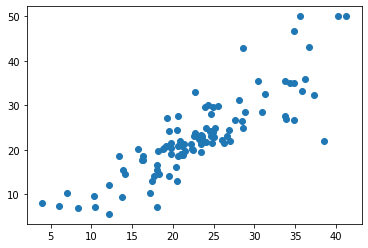

In [18]:
plt.scatter(grid_pred, y_test)
plt.show()